Link to Kaggle project: https://www.kaggle.com/code/rohantemujin/final-project

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')
sample = pd.read_csv('../input/plant-pathology-2020-fgvc7/sample_submission.csv')

In [4]:
base_path = "/kaggle/input/plant-pathology-2020-fgvc7/images/"

# Function to generate the image path based on the image_id
def generate_image_path(image_id):
    return f"{base_path}{image_id}.jpg"

# Apply the function to create the 'img' column
train['img'] = train['image_id'].apply(generate_image_path)
test['img'] = test['image_id'].apply(generate_image_path)

In [5]:
train

,image_id,healthy,multiple_diseases,rust,scab,img
0,Train_0,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/image...
1,Train_1,0,1,0,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
2,Train_2,1,0,0,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
3,Train_3,0,0,1,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
4,Train_4,1,0,0,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/image...
1817,Train_1817,1,0,0,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
1818,Train_1818,1,0,0,0,/kaggle/input/plant-pathology-2020-fgvc7/image...
1819,Train_1819,0,0,1,0,/kaggle/input/plant-pathology-2020-fgvc7/image...


In [6]:
test

,image_id,img
0,Test_0,/kaggle/input/plant-pathology-2020-fgvc7/image...
1,Test_1,/kaggle/input/plant-pathology-2020-fgvc7/image...
2,Test_2,/kaggle/input/plant-pathology-2020-fgvc7/image...
3,Test_3,/kaggle/input/plant-pathology-2020-fgvc7/image...
4,Test_4,/kaggle/input/plant-pathology-2020-fgvc7/image...
...,...,...
1816,Test_1816,/kaggle/input/plant-pathology-2020-fgvc7/image...
1817,Test_1817,/kaggle/input/plant-pathology-2020-fgvc7/image...
1818,Test_1818,/kaggle/input/plant-pathology-2020-fgvc7/image...
1819,Test_1819,/kaggle/input/plant-pathology-2020-fgvc7/image...


In [7]:
sample

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25
...,...,...,...,...,...
1816,Test_1816,0.25,0.25,0.25,0.25
1817,Test_1817,0.25,0.25,0.25,0.25
1818,Test_1818,0.25,0.25,0.25,0.25
1819,Test_1819,0.25,0.25,0.25,0.25


Image size: (2048, 1365)


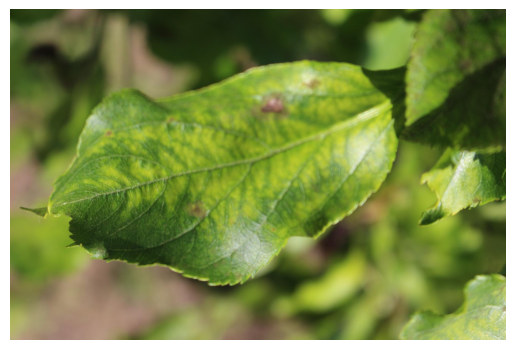

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

# Get the path of the first image
first_image_path = train['img'].iloc[0]

# Open the image
image = Image.open(first_image_path)

# Print the size of the image
print(f"Image size: {image.size}")

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

# Custom augmentation functions
def canny_edge(img):
    return cv2.Canny(img, 100, 200)

def apply_convolution(img):
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])  # Example kernel for edge detection
    return cv2.filter2D(img, -1, kernel)

def blur_image(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Preprocess the images
x = []
target_size = (204, 136)

for img_path in train['img']:
    try:
        img = cv2.imread(img_path)
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        resized_img = resized_img / 255.0
        
        x.append(resized_img)
        
        # Apply data augmentation
        flipped_img = cv2.flip(resized_img, 1)  # Horizontal flip
        flipped_img_v = cv2.flip(resized_img, 0)  # Vertical flip
        canny_img = canny_edge(cv2.cvtColor((resized_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY))
        canny_img = cv2.cvtColor(canny_img, cv2.COLOR_GRAY2RGB) / 255.0  # Convert to RGB and normalize
        conv_img = apply_convolution((resized_img * 255).astype(np.uint8)) / 255.0
        blur_img = blur_image((resized_img * 255).astype(np.uint8)) / 255.0
        
        x.append(flipped_img)
        x.append(flipped_img_v)
        x.append(canny_img)
        x.append(conv_img)
        x.append(blur_img)
        
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        continue

x = np.array(x)

# Prepare the target labels, repeating the labels for each augmented version
y = np.repeat(train[['healthy', 'multiple_diseases', 'rust', 'scab']].values, 6, axis=0)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define the model
model = Sequential()
model.add(Input(shape=[204, 136, 3])) # RGB input
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) # 32 filters
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 64 filters
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu')) # 128 neurons
model.add(Dropout(0.5)) # Add dropout
model.add(Dense(4, activation='sigmoid')) # Output layer with 4 neurons and sigmoid activation for multi-label classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

2024-07-13 06:35:42.186806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 06:35:42.186970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 06:35:42.426021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 240s 864ms/step - accuracy: 0.3294 - loss: 0.5978 - val_accuracy: 0.3847 - val_loss: 0.5110
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 236s 862ms/step - accuracy: 0.3768 - loss: 0.5204 - val_accuracy: 0.4437 - val_loss: 0.4992
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 267s 881ms/step - accuracy: 0.4700 - loss: 0.4892 - val_accuracy: 0.5700 - val_loss: 0.4549
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 231s 842ms/step - accuracy: 0.6343 - loss: 0.3968 - val_accuracy: 0.6400 - val_loss: 0.3935
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 239s 872ms/step - accuracy: 0.7405 - loss: 0.3061 - val_accuracy: 0.6908 - val_loss: 0.3701
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 262s 872ms/step - accuracy: 0.8137 - loss: 0.2373 - val_accuracy: 0.7333 - val_loss: 0.3471
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 235s 859ms/step - accuracy: 0.8712 - loss: 0.1795 - val_accuracy: 0.7443 - val_loss: 0.3422
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 238s 867ms/step - accuracy: 0.9029 -

69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step
ROC AUC scores:
healthy: 0.8809
multiple_diseases: 0.8230
rust: 0.9235
scab: 0.8967


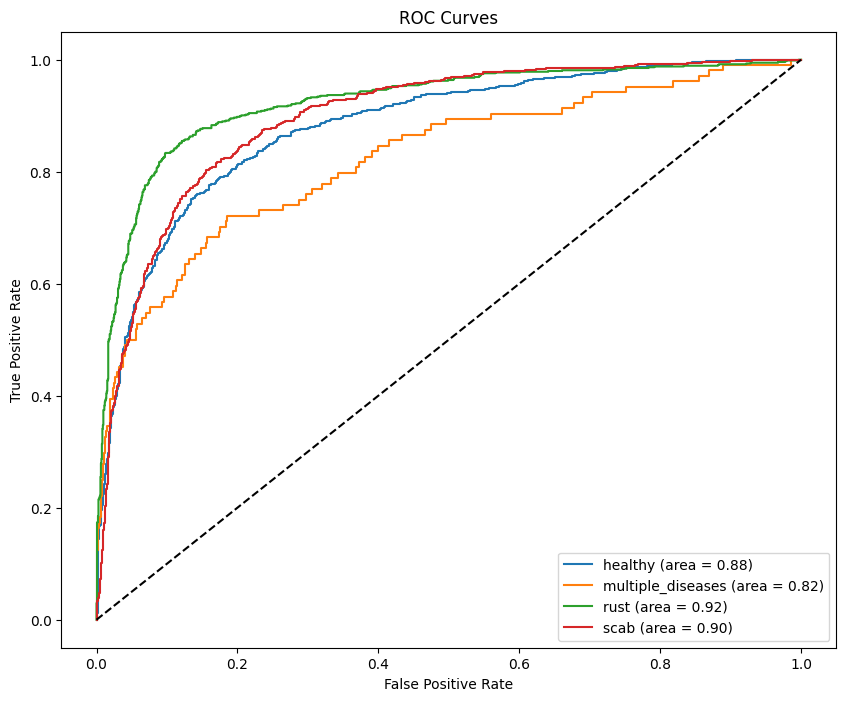

In [11]:
# Evaluate the model
y_pred_prob = model.predict(x_test)

# Calculate ROC AUC for each class
roc_auc_scores = {}
for i, class_name in enumerate(['healthy', 'multiple_diseases', 'rust', 'scab']):
    roc_auc_scores[class_name] = roc_auc_score(y_test[:, i], y_pred_prob[:, i])

print("ROC AUC scores:")
for class_name, score in roc_auc_scores.items():
    print(f"{class_name}: {score:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(['healthy', 'multiple_diseases', 'rust', 'scab']):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (area = {roc_auc_scores[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

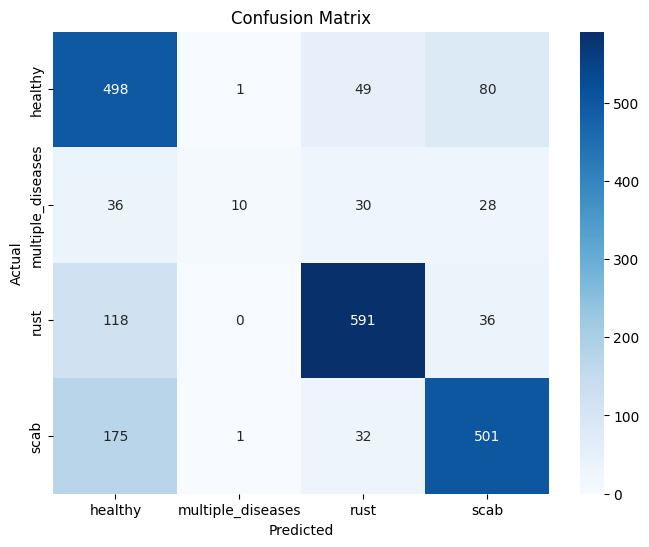

In [12]:
# Generate a confusion matrix
y_pred_binary = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_binary.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'], yticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
model.save('my_cnn_model.h5')

In [14]:
from keras.models import load_model

# Load the saved model
model = load_model('my_cnn_model.h5')

# Preprocess the test images
x_test = []
target_size = (204, 136)

for img_path in test['img']:
    try:
        # Read the image
        img = cv2.imread(img_path)
        
        # Convert the image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        # Normalize the image
        resized_img = resized_img / 255.0
        
        # Append to the list
        x_test.append(resized_img)
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        continue

# Convert the list to a numpy array
x_test = np.array(x_test)

# Predict the probabilities
predictions = model.predict(x_test)
# Create the output DataFrame
output = test[['image_id']].copy()
output[['healthy', 'multiple_diseases', 'rust', 'scab']] = predictions

# Save the predictions to a CSV file
output.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step
Predictions saved to predictions.csv


In [15]:
output

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.269240,0.377372,0.392709,1.570409e-01
1,Test_1,0.038582,0.006954,0.879953,1.317967e-02
2,Test_2,0.074911,0.012624,0.004500,9.175487e-01
3,Test_3,0.860939,0.034896,0.046987,1.054640e-01
4,Test_4,0.000007,0.000021,0.999918,9.500649e-07
...,...,...,...,...,...
1816,Test_1816,0.742369,0.099794,0.088164,1.554524e-02
1817,Test_1817,0.017186,0.019962,0.280165,7.431490e-01
1818,Test_1818,0.374523,0.044037,0.068401,3.350893e-01
1819,Test_1819,0.814255,0.002662,0.074258,3.053334e-02
